In [84]:
import os
import torch
import numpy as np
import pandas as pd
import kagglehub
from torchvision import datasets, transforms, models
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

device =  torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [85]:
path = kagglehub.dataset_download("pacificrm/skindiseasedataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/academic-city-university/.cache/kagglehub/datasets/pacificrm/skindiseasedataset/versions/6


In [86]:
path = "/Users/academic-city-university/.cache/kagglehub/datasets/pacificrm/skindiseasedataset/versions/6"

In [87]:
main_dir = os.path.join(path, "SkinDisease","SkinDisease")
train_dir = os.path.join(main_dir, "train")
test_dir = os.path.join(main_dir, "test")
print("Main Directory:", main_dir)

Main Directory: /Users/academic-city-university/.cache/kagglehub/datasets/pacificrm/skindiseasedataset/versions/6/SkinDisease/SkinDisease


In [88]:
image_paths=[]
image_labels=[]
class_dir = os.path.join(main_dir, "train")
class_names = os.listdir(class_dir)
num_classes = len(class_names)

In [89]:
for img_file in os.listdir(class_dir):
    img_path = os.path.join(class_dir, img_file)
    if os.path.isdir(img_path):
        for img in os.listdir(img_path):
            image_paths.append(os.path.join(img_path, img))
            image_labels.append(img_file)
print(f"Total images: {len(image_paths)}")
print(f"Total labels: {len(image_labels)}")

Total images: 13898
Total labels: 13898


In [90]:
df = pd.DataFrame({
    'image_path': image_paths,
    'label': image_labels
})

In [91]:
df

,image_path,label
0,/Users/academic-city-university/.cache/kaggleh...,Tinea
1,/Users/academic-city-university/.cache/kaggleh...,Tinea
2,/Users/academic-city-university/.cache/kaggleh...,Tinea
3,/Users/academic-city-university/.cache/kaggleh...,Tinea
4,/Users/academic-city-university/.cache/kaggleh...,Tinea
...,...,...
13893,/Users/academic-city-university/.cache/kaggleh...,Actinic_Keratosis
13894,/Users/academic-city-university/.cache/kaggleh...,Actinic_Keratosis
13895,/Users/academic-city-university/.cache/kaggleh...,Actinic_Keratosis
13896,/Users/academic-city-university/.cache/kaggleh...,Actinic_Keratosis


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13898 entries, 0 to 13897
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  13898 non-null  object
 1   label       13898 non-null  object
dtypes: object(2)
memory usage: 217.3+ KB


In [93]:
IMAGE_SIZE = 384
BATCH_SIZE = 32
EPOCHS = 25
LR = 0.001

In [94]:
# CutMix(Domain AMP), Test synthetic augmentation
def transfrom_train():
    return transforms.Compose([
        transforms.RandomResizedCrop(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def transfrom_test():
    return transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [95]:
train_dataset = datasets.ImageFolder(train_dir, transform=transfrom_train())
test_dataset = datasets.ImageFolder(test_dir, transform=transfrom_test())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [96]:
class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

Class names: ['Acne', 'Actinic_Keratosis', 'Benign_tumors', 'Bullous', 'Candidiasis', 'DrugEruption', 'Eczema', 'Infestations_Bites', 'Lichen', 'Lupus', 'Moles', 'Psoriasis', 'Rosacea', 'Seborrh_Keratoses', 'SkinCancer', 'Sun_Sunlight_Damage', 'Tinea', 'Unknown_Normal', 'Vascular_Tumors', 'Vasculitis', 'Vitiligo', 'Warts']
Number of classes: 22


In [97]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
print(f"Number of classes in train dataset: {len(train_dataset.classes)}")
print(f"Number of classes in test dataset: {len(test_dataset.classes)}")

Number of training samples: 13898
Number of testing samples: 1546
Number of classes in train dataset: 22
Number of classes in test dataset: 22


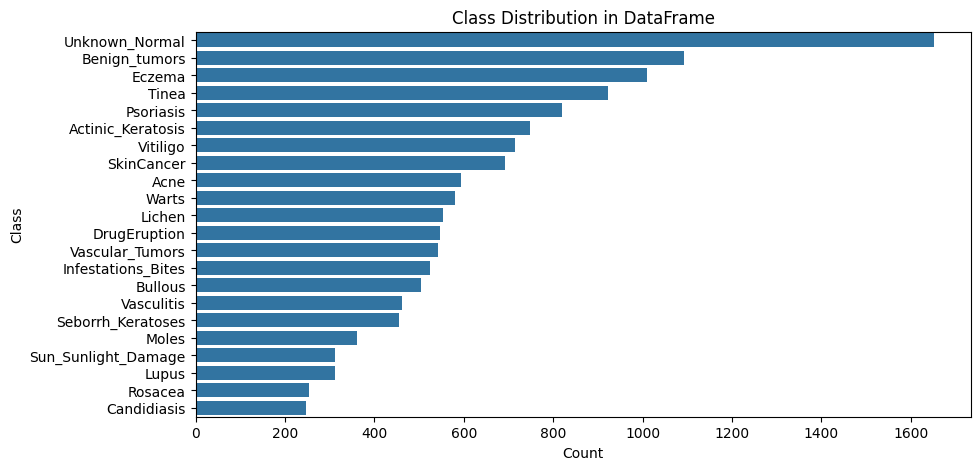

In [98]:
# Check class distribution
plt.figure(figsize=(10,5))
sns.countplot(y='label', data=df, order=df['label'].value_counts().index)
plt.title('Class Distribution in DataFrame') 
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

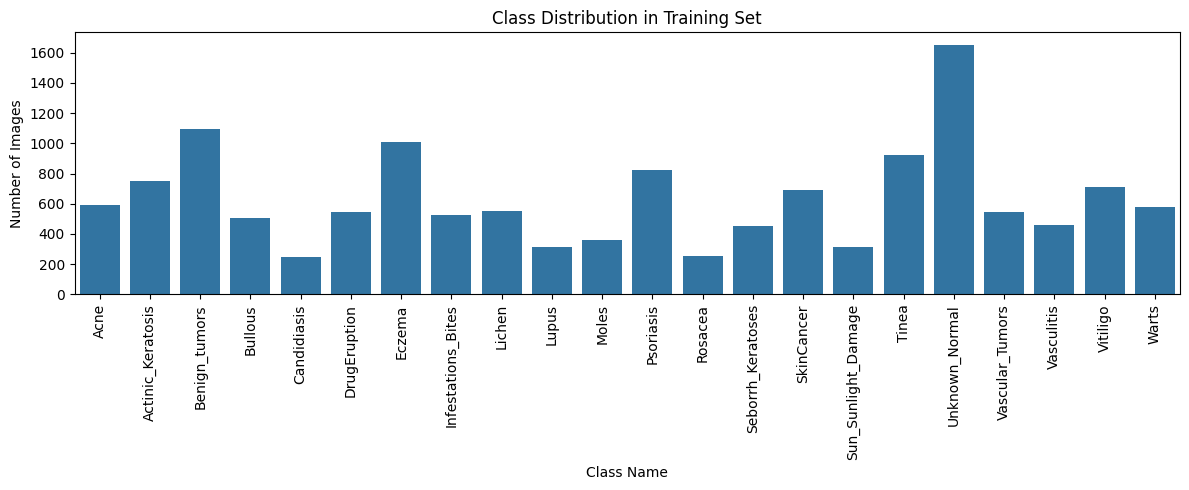

In [99]:
from collections import Counter

# Class distribution bar chart
label_counts = Counter(train_dataset.targets)
plt.figure(figsize=(12, 5))
sns.barplot(x=[class_names[i] for i in label_counts.keys()], y=list(label_counts.values()))
plt.xticks(rotation=90)
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Images")
plt.xlabel("Class Name")
plt.tight_layout()
plt.show()

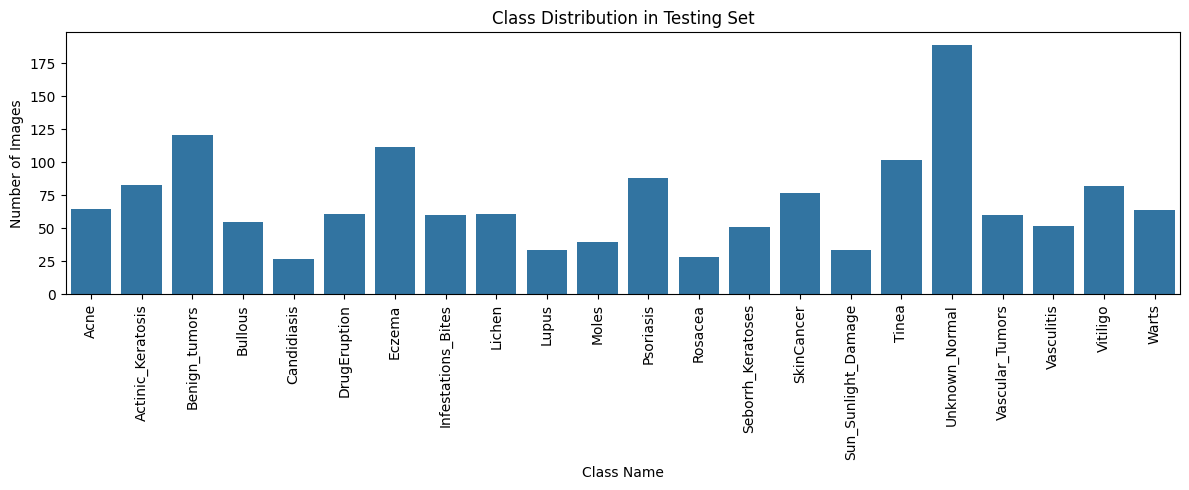

In [100]:
# Check class distribution in testing dataset
test_label_counts = Counter(test_dataset.targets)
plt.figure(figsize=(12, 5))
sns.barplot(x=[class_names[i] for i in test_label_counts.keys()], y=list(test_label_counts.values()))
plt.xticks(rotation=90)
plt.title("Class Distribution in Testing Set")
plt.ylabel("Number of Images")
plt.xlabel("Class Name")
plt.tight_layout()
plt.show()

In [101]:
#Data Exploration
import random
def plot_samples(dataset, class_names, num_samples=5):#Pick random samples
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        random_idx = random.randint(0, len(dataset)-1)
        img, label = dataset[random_idx]
        img = img.numpy().transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(img)
        plt.title(class_names[label])
        plt.axis("off")
    plt.show()

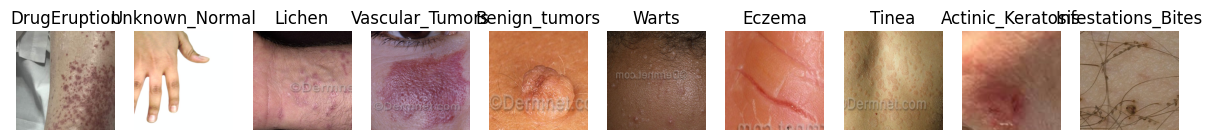

In [102]:
plot_samples(train_dataset, class_names, num_samples = 10)

In [103]:
labels = train_dataset.targets
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

Class weights: tensor([1.0653, 0.8446, 0.5780, 1.2534, 2.5473, 1.1549, 0.6255, 1.2056, 1.1424,
        2.0313, 1.7499, 0.7704, 2.4871, 1.3884, 0.9116, 2.0248, 0.6844, 0.3826,
        1.1634, 1.3703, 0.8848, 1.0892], device='mps:0')


In [104]:
# # Correct way to load pre-trained models in newer PyTorch versions
# model1 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
# model2 = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
# model3 = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)

# models = {model1: 'resnet50', model2: 'efficientnet_b3', model3: 'vit_b_16'}
# for model in models:
#     model.to(device)
#     print(f"{models[model]} loaded successfully!")

In [105]:
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.2)

In [106]:
# import pytorch_warmup as warmup

# optimizers = {
#     model1: optim.AdamW(model1.parameters(), lr=LR),
#     model2: optim.AdamW(model2.parameters(), lr=LR),
#     model3: optim.AdamW(model3.parameters(), lr=LR)
# }

# schedulers = {
#     model1: optim.lr_scheduler.CosineAnnealingLR(optimizers[model1], T_max=EPOCHS),
#     model2: optim.lr_scheduler.CosineAnnealingLR(optimizers[model2], T_max=EPOCHS),
#     model3: optim.lr_scheduler.CosineAnnealingLR(optimizers[model3], T_max=EPOCHS)
# }
# schedulers = {
#     model1: optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizers[model1], T_0=5, T_mult=2),
#     model2: optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizers[model2], T_0=5, T_mult=2),
#     model3: optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizers[model3], T_0=5, T_mult=2)
# }
# warmup_schedulers = {
#     model1: warmup.UntunedExponentialWarmup(optimizers[model1]),
#     model2: warmup.UntunedExponentialWarmup(optimizers[model2]),
#     model3: warmup.UntunedExponentialWarmup(optimizers[model3])
# }

In [107]:
# Split train dataset into training and validation sets
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset
train_indices, val_indices = train_test_split(
    np.arange(len(train_dataset)),
    test_size=0.2,
    stratify=train_dataset.targets,
    random_state=42
)
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Number of training samples: {len(train_subset)}")
print(f"Number of validation samples: {len(val_subset)}")


Number of training samples: 11118
Number of validation samples: 2780


In [108]:
def create_model(base_model, num_classes):
    if base_model == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
    elif base_model == "efficientnet_b3":
        model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, num_classes)
    elif base_model == "inception_v3":
        model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
        # Update AuxLogits if present
        if model.AuxLogits is not None:
            aux_in_features = model.AuxLogits.fc.in_features
            model.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)
    else:
        raise ValueError(f"Unsupported model type: {base_model}")
    
    return model 

In [109]:
model1 = create_model("resnet50", num_classes).to(device)
model2 = create_model("efficientnet_b3", num_classes).to(device)
model3 = create_model("inception_v3", num_classes).to(device)

models =  {model1: 'resnet50', model2: 'efficientnet_b3', model3: 'inception_v3'}

In [111]:

# Create optimizer, scheduler, etc.
optimizers = {
    model1: torch.optim.Adam(model1.parameters(), lr=0.001),
    model2: torch.optim.Adam(model2.parameters(), lr=0.001),
    model3: torch.optim.Adam(model3.parameters(), lr=0.001)
}

# Create the scheduler without weight tensors or with matching weight tensors
schedulers = {
    model1: torch.optim.lr_scheduler.CosineAnnealingLR(optimizers[model1], T_max=10),
    model2: torch.optim.lr_scheduler.CosineAnnealingLR(optimizers[model2], T_max=10),
    model3: torch.optim.lr_scheduler.CosineAnnealingLR(optimizers[model3], T_max=10)
}

# Example warmup scheduler (if needed)
class WarmupScheduler:
    def __init__(self, optimizer, warmup_steps):
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.current_step = 0
        
    def step(self):
        self.current_step += 1
        
    def get_lr(self):
        return [base_lr * min(1.0, self.current_step / self.warmup_steps) 
                for base_lr in self.base_lrs]

warmup_schedulers = {
    model1: WarmupScheduler(optimizers[model1], warmup_steps=5),
    model2: WarmupScheduler(optimizers[model2], warmup_steps=5),
    model3: WarmupScheduler(optimizers[model3], warmup_steps=5)
}

In [113]:
# Training loop
def train_model(model, optimizer, scheduler, warmup_scheduler, num_epochs=EPOCHS):
    best_val_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if warmup_scheduler is not None:
                warmup_scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= total
        val_acc = correct / total

        if scheduler is not None:
            scheduler.step()

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"best_model_{models[model]}.pth")
            print(f"Best model saved with accuracy: {best_val_acc:.4f}")

    return history

**Starting with the ResNet50 model** 

In [ ]:
train_model(model1, optimizers[model1], schedulers[model1], warmup_schedulers[model1], num_epochs=100)

Epoch [1/100], Train Loss: 3.0934, Train Acc: 0.1391, Val Loss: 3.0410, Val Acc: 0.1766
Best model saved with accuracy: 0.1766
Epoch [2/100], Train Loss: 2.9778, Train Acc: 0.2086, Val Loss: 2.9710, Val Acc: 0.2331
Best model saved with accuracy: 0.2331
Epoch [3/100], Train Loss: 2.9135, Train Acc: 0.2406, Val Loss: 2.8930, Val Acc: 0.2773
Best model saved with accuracy: 0.2773
Epoch [4/100], Train Loss: 2.8440, Train Acc: 0.2748, Val Loss: 2.8573, Val Acc: 0.2741
Epoch [5/100], Train Loss: 2.7834, Train Acc: 0.3010, Val Loss: 2.7592, Val Acc: 0.3266
Best model saved with accuracy: 0.3266
Epoch [6/100], Train Loss: 2.7106, Train Acc: 0.3351, Val Loss: 2.7293, Val Acc: 0.3399
Best model saved with accuracy: 0.3399
Epoch [7/100], Train Loss: 2.6504, Train Acc: 0.3639, Val Loss: 2.6694, Val Acc: 0.3547
Best model saved with accuracy: 0.3547
Epoch [8/100], Train Loss: 2.5803, Train Acc: 0.3966, Val Loss: 2.6044, Val Acc: 0.4137
Best model saved with accuracy: 0.4137
Epoch [9/100], Train Lo

In [ ]:
train_model(model2, optimizers[model2], schedulers[model2], warmup_schedulers[model2], num_epochs=100)

Epoch [1/100], Train Loss: 2.7168, Train Acc: 0.3486, Val Loss: 2.5469, Val Acc: 0.4486
Best model saved with accuracy: 0.4486
Epoch [2/100], Train Loss: 2.4354, Train Acc: 0.4750, Val Loss: 2.3364, Val Acc: 0.5187
Best model saved with accuracy: 0.5187
Epoch [3/100], Train Loss: 2.2628, Train Acc: 0.5537, Val Loss: 2.2808, Val Acc: 0.5622
Best model saved with accuracy: 0.5622
Epoch [4/100], Train Loss: 2.1477, Train Acc: 0.6050, Val Loss: 2.1766, Val Acc: 0.6187
Best model saved with accuracy: 0.6187


In [115]:
def train_inception(model, optimizer, scheduler, warmup_scheduler=None, num_epochs=EPOCHS):
    best_val_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # 🔹 Handle Inception’s auxiliary outputs
            if isinstance(outputs, tuple) or hasattr(outputs, "aux_logits"):
                if hasattr(outputs, "logits"):
                    main_output = outputs.logits
                    aux_output = outputs.aux_logits
                else:
                    main_output, aux_output = outputs  # older torchvision versions

                loss1 = criterion(main_output, labels)
                loss2 = criterion(aux_output, labels)
                loss = loss1 + 0.4 * loss2  # Weighted auxiliary loss
                outputs = main_output  # For accuracy calculation
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            if warmup_scheduler is not None:
                warmup_scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        # 🔸 Validation Phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                # Handle validation outputs
                if isinstance(outputs, tuple) or hasattr(outputs, "logits"):
                    outputs = outputs.logits

                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= total
        val_acc = correct / total

        if scheduler is not None:
            scheduler.step()

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # 🔹 Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model_inception_v3.pth")
            print(f"Best model saved with accuracy: {best_val_acc:.4f}")

    return history


In [116]:
history_inception = train_inception(model3, optimizers[model3], schedulers[model3], warmup_schedulers[model3], num_epochs=100)

Epoch [1/100] | Train Loss: 4.3369 | Train Acc: 0.1421 | Val Loss: 3.0884 | Val Acc: 0.1860
✅ Best model saved with accuracy: 0.1860
Epoch [2/100] | Train Loss: 4.1495 | Train Acc: 0.2240 | Val Loss: 2.9722 | Val Acc: 0.2266
✅ Best model saved with accuracy: 0.2266
Epoch [3/100] | Train Loss: 4.0049 | Train Acc: 0.2617 | Val Loss: 2.8712 | Val Acc: 0.2698
✅ Best model saved with accuracy: 0.2698
Epoch [4/100] | Train Loss: 3.8854 | Train Acc: 0.3055 | Val Loss: 2.7501 | Val Acc: 0.3266
✅ Best model saved with accuracy: 0.3266
Epoch [5/100] | Train Loss: 3.7561 | Train Acc: 0.3476 | Val Loss: 2.6678 | Val Acc: 0.3572
✅ Best model saved with accuracy: 0.3572
Epoch [6/100] | Train Loss: 3.6567 | Train Acc: 0.3817 | Val Loss: 2.6103 | Val Acc: 0.3845
✅ Best model saved with accuracy: 0.3845
Epoch [7/100] | Train Loss: 3.5515 | Train Acc: 0.4146 | Val Loss: 2.5190 | Val Acc: 0.4363
✅ Best model saved with accuracy: 0.4363
Epoch [8/100] | Train Loss: 3.4467 | Train Acc: 0.4487 | Val Loss: 2.

In [29]:
model1.load_state_dict(torch.load("best_model_resnet50.pth"))

<All keys matched successfully>

In [30]:
model2.load_state_dict(torch.load("best_model_efficientnet_b3.pth"))

<All keys matched successfully>

In [117]:
model3.load_state_dict(torch.load("best_model_inception_v3.pth"))

<All keys matched successfully>

In [121]:
# Model Fusion Techniques: Simple Averaging 

def fuse_predictions(models, dataloader):
    all_preds = []

    for model in models:
        model.eval()
        preds = []

        with torch.no_grad():
            for inputs, _ in dataloader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                probs = nn.Softmax(dim=1)(outputs)
                preds.append(probs.cpu().numpy())

        all_preds.append(np.concatenate(preds, axis=0))

    # Average predictions
    fused_preds = np.mean(all_preds, axis=0)
    return fused_preds

Classification Report for Fused Model:
                     precision    recall  f1-score   support

               Acne       0.88      0.82      0.85        65
  Actinic_Keratosis       0.69      0.76      0.72        83
      Benign_tumors       0.63      0.70      0.67       121
            Bullous       0.65      0.65      0.65        55
        Candidiasis       0.57      0.78      0.66        27
       DrugEruption       0.66      0.62      0.64        61
             Eczema       0.72      0.61      0.66       112
 Infestations_Bites       0.69      0.48      0.57        60
             Lichen       0.68      0.62      0.65        61
              Lupus       0.53      0.59      0.56        34
              Moles       0.61      0.62      0.62        40
          Psoriasis       0.73      0.69      0.71        88
            Rosacea       0.69      0.71      0.70        28
  Seborrh_Keratoses       0.83      0.78      0.81        51
         SkinCancer       0.64      0.61     

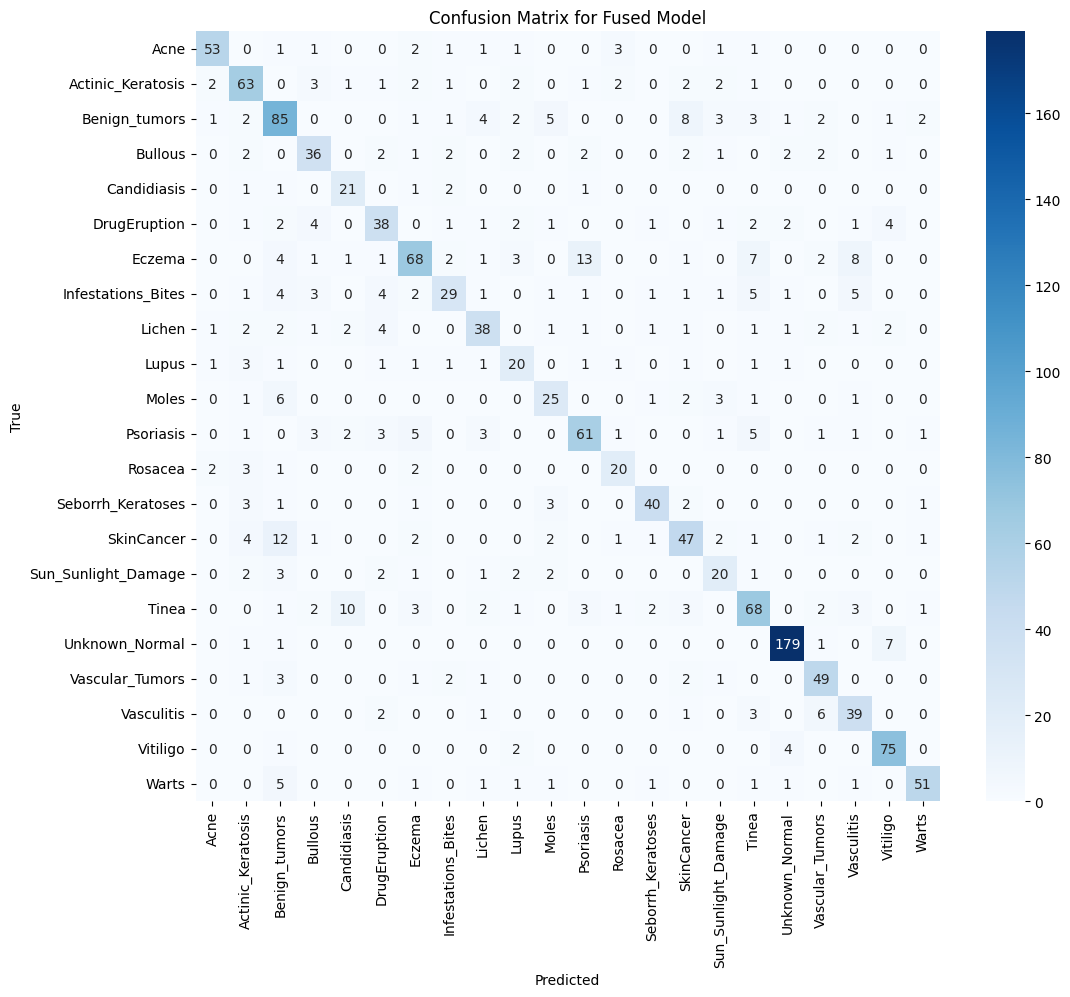

Fused Model Test Accuracy (Averaging): 0.7277


In [122]:
fused_test_preds = fuse_predictions([model1, model2, model3], test_loader)
fused_test_labels = []
for _, labels in test_loader:
    fused_test_labels.extend(labels.numpy())
fused_test_labels = np.array(fused_test_labels)
fused_test_pred_classes = np.argmax(fused_test_preds, axis=1)
from sklearn.metrics import classification_report, confusion_matrix 
print("Classification Report for Fused Model:")
print(classification_report(fused_test_labels, fused_test_pred_classes, target_names=class_names))
cm = confusion_matrix(fused_test_labels, fused_test_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Fused Model')
plt.show()

avg_fusion_test_acc = np.mean(fused_test_pred_classes == fused_test_labels)
print(f"Fused Model Test Accuracy (Averaging): {avg_fusion_test_acc:.4f}")

In [124]:
# Model Fusion Techniques: Weighted Averaging
def fuse_predictions_weighted(models, dataloader, weights):
    all_preds = []

    for model in models:
        model.eval()
        preds = []

        with torch.no_grad():
            for inputs, _ in dataloader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                probs = nn.Softmax(dim=1)(outputs)
                preds.append(probs.cpu().numpy())

        all_preds.append(np.concatenate(preds, axis=0))

    # Weighted average predictions
    fused_preds = np.zeros_like(all_preds[0])
    for preds, weight in zip(all_preds, weights):
        fused_preds += weight * preds
    return fused_preds

In [125]:
fused_test_preds_weighted = fuse_predictions_weighted([model1, model2, model3], test_loader, weights=[0.5, 0.2, 0.3])
fused_test_pred_classes_weighted = np.argmax(fused_test_preds_weighted, axis=1)
weighted_fusion_test_acc = np.mean(fused_test_pred_classes_weighted == fused_test_labels)
print(f"Fused Model Test Accuracy (Weighted Averaging): {weighted_fusion_test_acc:.4f}")

Fused Model Test Accuracy (Weighted Averaging): 0.7257


In [126]:
# Fuse for model 1 and 2 only with weights
fused_test_preds_weighted_12 = fuse_predictions_weighted([model1, model3], test_loader, weights=[0.65, 0.35])
fused_test_pred_classes_weighted_12 = np.argmax(fused_test_preds_weighted_12, axis=1)
weighted_fusion_test_acc_12 = np.mean(fused_test_pred_classes_weighted_12 == fused_test_labels)
print(f"Fused Model Test Accuracy (Model 1 & 2 Weighted Averaging): {weighted_fusion_test_acc_12:.4f}")

Fused Model Test Accuracy (Model 1 & 2 Weighted Averaging): 0.7257
